In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

print(tf.__version__)

1.2.0


## Prediction / regression pipeline

Here we try to predict y(t) based on x(s <= t). y(t) may be x(t+1).

In [2]:
batch_size = 128
d_x = 1
d_y = 1

## Making room for the sequences

Let's create placeholders for our input data x and output data y.

In [3]:
# We do not assume we know the sequence length yet

x_seq_ph = tf.placeholder(shape=(batch_size, None, d_x), dtype=tf.float32)
y_seq_ph = tf.placeholder(shape=(batch_size, None, d_y), dtype=tf.float32)

## Preparing the network's modules

Let's define a convolution layer

In [4]:
def convolution_layer(input_seq, n_dims_in, n_dims_out, width, 
                      dilation=1, causal=True):
    conv_kernel = tf.get_variable(
        name="kernel",
        shape=[width, n_dims_in, n_dims_out], 
        dtype=tf.float32,
        initializer=tf.truncated_normal_initializer())
    
    # Similar to approach in Francois Chollet's Keras library
    if causal:
        offset = dilation * (width - 1)
        input_seq = tf.pad(input_seq, [[0, 0], [offset, 0], [0, 0]])
    
    conv_output = tf.nn.convolution(
        input=input_seq,
        filter=conv_kernel,
        padding="VALID" if causal else "SAME",
        strides=None,
        dilation_rate=[dilation]
    )
    
    return conv_output

## A simple auto-regressive model

Let's build a AR(p) model with tensorflow

In [5]:
p = 3

with tf.variable_scope("AR_p_model"):
    y_predicted = convolution_layer(x_seq_ph, d_x, d_y, width=p)

In [6]:
loss = tf.reduce_sum(tf.nn.l2_loss(y_predicted - y_seq_ph))

In [7]:
learning_rate = 1e-3

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(loss)

## Pathological example with white noise

In [8]:
def generate_samples(batch_size, sequence_length, n_dims):
    return np.random.normal(0.0, 1.0, (batch_size, sequence_length, n_dims))

## Let's try to predict a noisy version of the current value

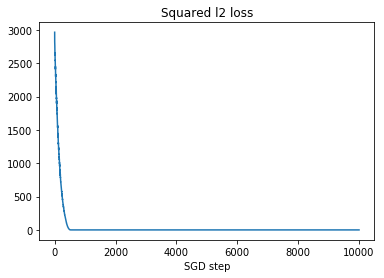

In [9]:
n_steps = int(1e4)
sequence_length = 128

session = tf.Session()

session.run(tf.global_variables_initializer())

loss_evals = []

for step in xrange(n_steps):
    x_seq = generate_samples(batch_size, sequence_length, 1)
    y_seq = x_seq + np.random.normal(0.0, 0.01, (batch_size, sequence_length, d_x))
    
    loss_eval, _ = session.run((loss, optimizer), 
                               feed_dict={x_seq_ph: x_seq,
                                          y_seq_ph: y_seq})

    loss_evals.append(loss_eval)
    
plt.plot(loss_evals)
plt.title("Squared l2 loss")
plt.xlabel("SGD step")
plt.show()

In [10]:
variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="AR_p_model")

print([v.name for v in variables])
kernel = [v for v in variables if "kernel" in v.name.split('/')[-1]][0]

kernel_eval = session.run(kernel)

[u'AR_p_model/kernel:0', u'AR_p_model/kernel/RMSProp:0', u'AR_p_model/kernel/RMSProp_1:0']


## Let's examine the kernel, what is going on there?

Here do we get the kernel shape we expect?

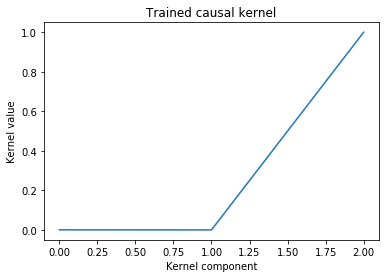

In [11]:
plt.plot(kernel_eval[:,0,0])
plt.title("Trained causal kernel")
plt.ylabel("Kernel value")
plt.xlabel("Kernel component")
plt.show()